# 1.4 신경망으로 문제를 풀다

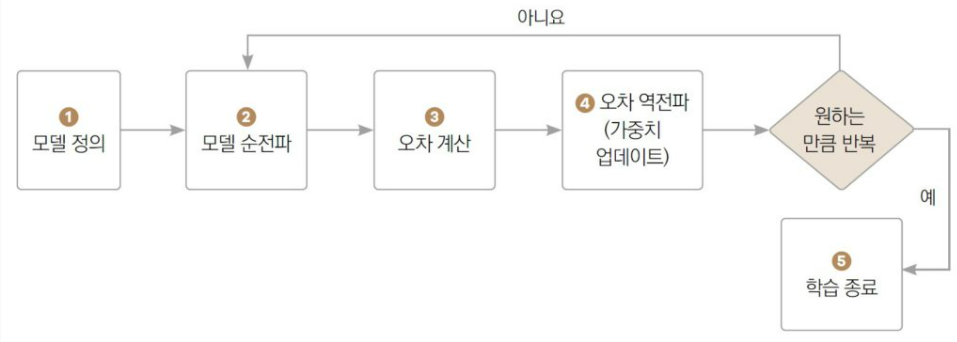

## 1.4.1 스파이럴 데이터셋

In [ ]:
# coding: utf-8
import numpy as np


def load_data(seed=1984):
    np.random.seed(seed)
    N = 100  # 클래스당 샘플 수
    DIM = 2  # 데어터 요소 수
    CLS_NUM = 3  # 클래스 수

    x = np.zeros((N*CLS_NUM, DIM))
    #t = np.zeros((N*CLS_NUM, CLS_NUM), dtype=np.int)
    t = np.zeros((N*CLS_NUM, CLS_NUM), dtype=int)

    for j in range(CLS_NUM):
        for i in range(N): # N*j, N*(j+1)):
            rate = i / N
            radius = 1.0*rate
            theta = j*4.0 + 4.0*rate + np.random.randn()*0.2

            ix = N*j + i
            x[ix] = np.array([radius*np.sin(theta),
                              radius*np.cos(theta)]).flatten()
            t[ix, j] = 1

    return x, t

In [ ]:
import sys
sys.path.append('..')
# from dataset import spiral
import matplotlib.pyplot as plt

x, t = load_data()
print('x', x.shape)
print('t', t.shape)


x (300, 2)
t (300, 3)


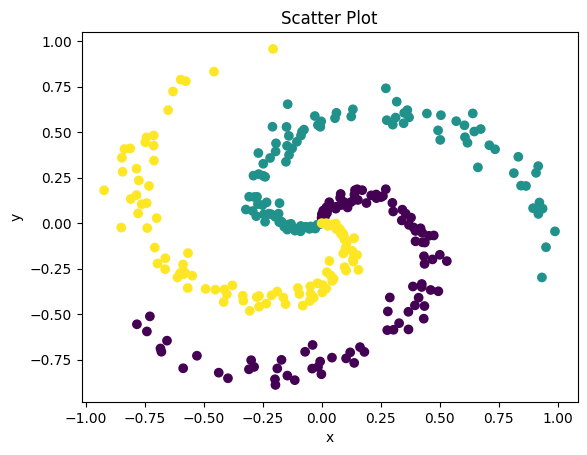

In [ ]:
plt.scatter(x[:, 0], x[:, 1], c=np.argmax(t, axis=1))
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter Plot')
plt.show()

In [ ]:
def softmax(x):
    if x.ndim == 2:
        # overflow를 막기 위해 입력값 중
        # 최대값을 빼준다. >> 밑러닝-1, 3.5.2 참고
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 정답 데이터가 원핫 벡터일 경우 정답 레이블 인덱스로 변환
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]

    cross_entropy = np.log(y[np.arange(batch_size), t] + 1e-7)
    loss = -np.sum(cross_entropy) / batch_size

    return loss

In [ ]:
class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        out = np.matmul(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        W, b = self.params
        dx = np.matmul(dout, W.T)
        dW = np.matmul(self.x.T, dout)
        db = np.sum(dout, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx

class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmax의 출력
        self.t = None  # 정답 레이블

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 정답 레이블이 원핫 벡터일 경우 정답의 인덱스로 변환
        # cross_entropy_error()에 이미 있어서 굳이 필요 없을 듯
        if self.t.size == self.y.size:
            self.t = self.t. argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx /= batch_size

        return dx

In [ ]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        I, H, O = input_size, hidden_size, output_size

        # 가중치(무작위 값이 좋다)와 편향(영벡터로 초기화) 초기화
        W1 = 0.01 * np.random.randn(I, H)
        b1 = np.zeros(H)
        W2 = 0.01 * np.random.randn(H, O)
        b2 = np.zeros(O)

        # 레이어 생성
        self.layers = [
            Affine(W1, b1),
            Sigmoid(),
            Affine(W2, b2)
        ]
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def forward(self, x, t):
        score = self.predict(x)
        loss = self.loss_layer.forward(score, t)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

In [ ]:
class SGD:
    '''
    확률적 경사하강법(SGD, Stochastic Gradient Descent)
        W <- W - lr * (dL/dW)
    '''
    def __init__(self, lr=0.01):
        self.lr = lr  # learning rate

    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]

In [ ]:
import matplotlib.font_manager as fm
font_list = fm.findSystemFonts(fontpaths=None, fontext = 'ttf')

In [ ]:
font_list

['/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-Italic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-Italic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf',
 '/usr/share/fonts/truetype/humor-sans/Humor-Sans.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf',
 '/usr/share/fonts/truetype/liberation/Lib

In [ ]:
f = [f.name for f in fm.fontManager.ttflist]
f

['STIXSizeThreeSym',
 'STIXNonUnicode',
 'STIXNonUnicode',
 'STIXSizeThreeSym',
 'cmsy10',
 'DejaVu Sans Mono',
 'STIXNonUnicode',
 'DejaVu Sans Display',
 'cmex10',
 'cmtt10',
 'DejaVu Serif',
 'DejaVu Sans',
 'DejaVu Sans',
 'DejaVu Sans Mono',
 'STIXSizeTwoSym',
 'STIXGeneral',
 'cmmi10',
 'cmss10',
 'STIXSizeOneSym',
 'STIXGeneral',
 'STIXSizeOneSym',
 'cmb10',
 'DejaVu Serif',
 'STIXNonUnicode',
 'STIXSizeFourSym',
 'DejaVu Serif',
 'STIXSizeFourSym',
 'DejaVu Sans',
 'STIXGeneral',
 'STIXSizeTwoSym',
 'DejaVu Sans Mono',
 'DejaVu Sans Mono',
 'STIXGeneral',
 'STIXSizeFiveSym',
 'DejaVu Serif',
 'DejaVu Serif Display',
 'DejaVu Sans',
 'cmr10',
 'Liberation Sans',
 'Liberation Sans',
 'Liberation Sans Narrow',
 'Liberation Serif',
 'Humor Sans',
 'Liberation Mono',
 'Liberation Sans Narrow',
 'Liberation Serif',
 'Liberation Serif',
 'Liberation Sans',
 'Liberation Serif',
 'Liberation Mono',
 'Liberation Sans',
 'Liberation Mono',
 'Liberation Sans Narrow',
 'Liberation Mono',
 '

### 1.4.3 학습용 코드

100%|██████████| 300/300 [00:00<00:00, 920.43it/s]


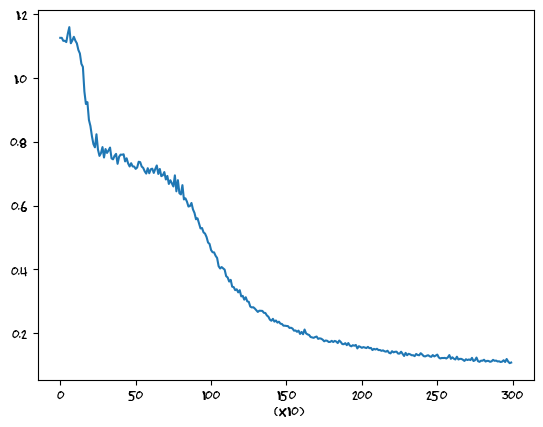

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

# matplotlib.rc('font', family='Malgun Gothic')  # linux
# matplotlib.rc('font', family='AppleGothic')  # Mac
matplotlib.rc('font', family='Humor Sans')

# 1. 하이퍼파라미터 설정
max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1.0

# 2. 데이터 읽기, 모델과 옵티마이저 생성
x, t = load_data()
model = TwoLayerNet(input_size=2,
                    hidden_size=hidden_size,
                    output_size=3)
optimizer = SGD(lr=learning_rate)

# 학습에 사용하는 변수
data_size = len(x)
max_iters = data_size // batch_size
total_loss = 0
loss_count = 0
loss_list = []

for epoch in tqdm(range(max_epoch)):
    # 3. 데이터 셔플링
    idx = np.random.permutation(data_size)
    x = x[idx]
    t = t[idx]

    for iters in range(max_iters):
        # 셔플된 데이터에서 순서대로 batch 크기만큼 선택하여 순서대로학습
        # batch_size * max_iters = 1 epoch
        batch_x = x[iters*batch_size:(iters+1)*batch_size]
        batch_t = t[iters*batch_size:(iters+1)*batch_size]

        # 기울기를 구해 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)

        total_loss += loss
        loss_count += 1

        # 정기적으로 학습 경과 출력
        if (iters+1) % 10 == 0:
            avg_loss = total_loss / loss_count
            # print(f'| 에폭 {epoch+1} | 반복{iters+1}/{max_iters} | 손실 {avg_loss:.2f}')
            loss_list.append(avg_loss)
            total_loss, loss_count = 0, 0



# 학습 결과 플롯
plt.plot(np.arange(len(loss_list)), loss_list, label='train')
plt.xlabel('반복 (x10)')
plt.ylabel('손실')
plt.show()

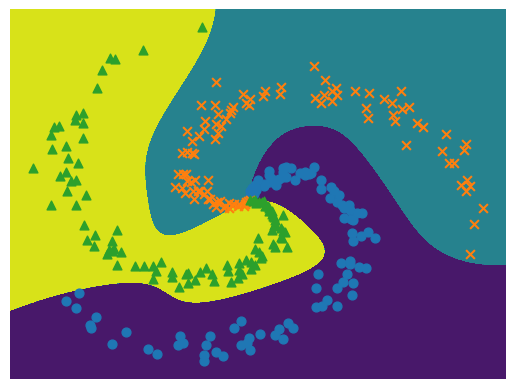

In [ ]:

# 경계 영역 플롯
h = 0.001
x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.c_[xx.ravel(), yy.ravel()]
score = model.predict(X)
predict_cls = np.argmax(score, axis=1)
Z = predict_cls.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis('off')

# 데이터점 플롯
x, t = load_data()
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
    plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()

--------------------------------------------------------------------------------

※permutation vs shuffle

In [ ]:
a= [1,2,3,4,5]
b = np.random.permutation(a)
c = [1,2,3,4,5]
d = np.random.shuffle(c)
e =

print(a)
print(b)
print(c)
print(d)

[1, 2, 3, 4, 5]
[5 2 4 1 3]
[2, 4, 3, 1, 5]
None


In [ ]:
print(np.array(a))

[1 2 3 4 5]


### 1.4.4 Trainer 클래스

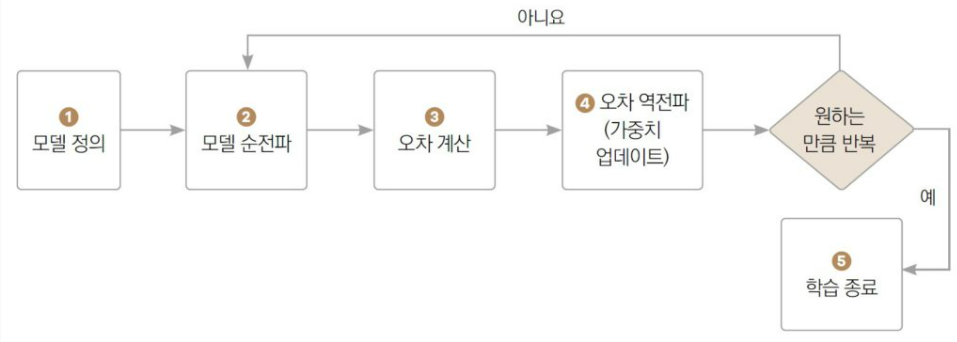

Trainer라는 '학습을 수행하는 코드'를 클래스 구현

model = TwoLayerNet(...)<br>
optimizer = SGD(lr=1.0)<br>
trainer = Trainer(model, optimizer)

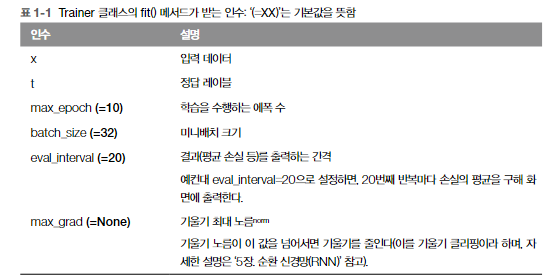

In [ ]:
import sys
sys.path.append('..')
import time
import numpy
import matplotlib.pyplot as plt
# from common.np import *
# from common.util import clip_grads

class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10,
            batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # 뒤섞기
            idx = numpy.random.permutation(numpy.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 기울기 구해 매개변수 갱신
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 평가
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    # print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 손실 %.2f'
                    #      % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('Iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('Loss')
        plt.show()

def remove_duplicate(params, grads):
    '''
    매개변수 배열 중 중복되는 가중치를 하나로 모아
    그 가중치에 대응하는 기울기를 더한다.
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 가중치 공유 시
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 경사를 더함
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 가중치를 전치행렬로 공유하는 경우(weight tying)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

자주 사용하는 학습 코드를 Class로 만들어 놓으면 간단하게 학습 시킬 수 있다.

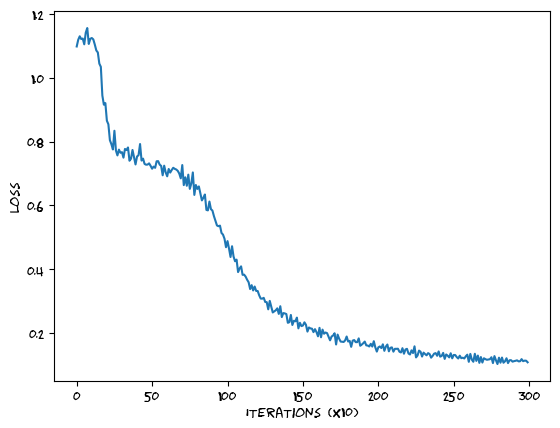

In [ ]:
# from common.trainer import Trainer
# from common.optimizer import SGD
# from dataset import spiral

import numpy as np
# from common.layers import Affine, Sigmoid, SoftmaxWithLoss

max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1.0

x, t = load_data()
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr=learning_rate)

trainer = Trainer(model, optimizer)
trainer.fit(x, t, max_epoch, batch_size, eval_interval=10)

trainer.plot()

# ※ keras에서는 Trainer와 같은 역할을 하는 Model 클래스를 제공하고 있음

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Keras에서 제공하는 함수형API로 모델 layer를 생성하고...
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data (these are NumPy arrays)
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# Keras에서 제공하는 Model 클래스의 compile() 메서드로 훈련 구성(optimizer, loss함수, metric) 지정
model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Keras에서 제공하는 Model 클래스의 fit() 메서드로 훈련 조건 지정
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=2,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)

Epoch 1/2
782/782 [==============================] - 3s 3ms/step - loss: 0.3408 - sparse_categorical_accuracy: 0.9039 - val_loss: 0.1858 - val_sparse_categorical_accuracy: 0.9461
Epoch 2/2
782/782 [==============================] - 2s 2ms/step - loss: 0.1565 - sparse_categorical_accuracy: 0.9533 - val_loss: 0.1669 - val_sparse_categorical_accuracy: 0.9518


In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape:", predictions.shape)

Evaluate on test data
79/79 [==============================] - 0s 2ms/step - loss: 0.1669 - sparse_categorical_accuracy: 0.9471
test loss, test acc: [0.16690848767757416, 0.9470999836921692]
Generate predictions for 3 samples
1/1 [==============================] - 0s 64ms/step
predictions shape: (3, 10)


--------------------------------------------------------------------------------

# ※ MNIST 예제를 통한 Keras, PyTorch 비교<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;https://yong0810.tistory.com/19

PyTorch가 스크래치 구현과 비슷하다?

--------------------------------------------------------------------------------

## 1.5 계산 고속화

### 1.5.1 비트 정밀도

In [ ]:
import numpy as np
a = np.random.randn(3)
a.dtype

dtype('float64')

In [ ]:
b = np.random.randn(3).astype(np.float32)
b.dtype

dtype('float32')

In [ ]:
c = np.random.randn(3).astype('f')
c.dtype

dtype('float32')

장점: 메모리, 버스 대역폭, 계산속도(일반적으로...)

16비트 부동소수점은? 처리속도 측면에서는 별로(계산 32비트 처리)...메모리 사용면에서는 유리...

--------------------------------------------------------------------------------

### 1.5.2 GPU(쿠파이)

딥러닝의 연산은 대부분 곱하기 연산 → 병렬 처리를 위한 GPU 유리

쿠파이: GPU를 이용해 병렬 계산을 수행해주는 라이브러리, 엔비디아 GPU에서만 동작<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Numpy 코드를 CUDA를 사용하여 GPU 가속 처리

Numpy vs CuPy 성능 비교

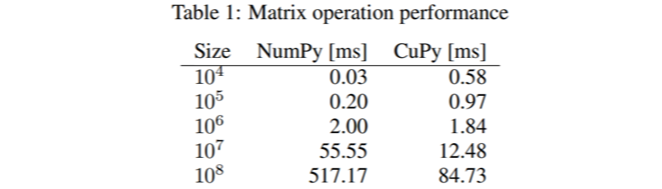

※ colab에서 cupy 사용하려면 런타임 유형을 GPU로 설정하고 import해야 error 뜨지 않음

런타임 유형 GPU

In [ ]:
import cupy as cp
import numpy as np
import time

In [ ]:
s = time.time()
x_gpu = cp.ones((1000,1000,1000))
cp.cuda.Stream.null.synchronize()
e = time.time()
print(e - s)

s = time.time()
x_cpu = np.ones((1000,1000,1000))
e = time.time()
print(e - s)

1.0404610633850098
1.8380064964294434


런타임 유형 CPU

In [ ]:
import numpy as np
import time

s = time.time()
x_cpu = np.ones((1000,1000,1000))
e = time.time()
print(e - s)

2.8963656425476074


In [ ]:
x_cpu.shape

(1000, 1000, 1000)

In [ ]:
del x_cpu

In [ ]:
import cupy as cp

ImportError: ignored

# 1권 복습 내용 추가

### 6.2 가중치의 초깃값: 신경망 학습의 성패를 결정하는 요인

In [ ]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        I, H, O = input_size, hidden_size, output_size

        # 가중치(무작위 값이 좋다)와 편향(영벡터로 초기화) 초기화
        W1 = 0.01 * np.random.randn(I, H)
        b1 = np.zeros(H)
        W2 = 0.01 * np.random.randn(H, O)
        b2 = np.zeros(O)


① 가중치 0으로 초기화<br>
활성화 함수 출력: 0(tanh) or 0.5(sigmoid) or 모든 클래스 확률 동등(softmax)<br>
학습이 진행되지 않음. 가중치0 ,local gradient 0

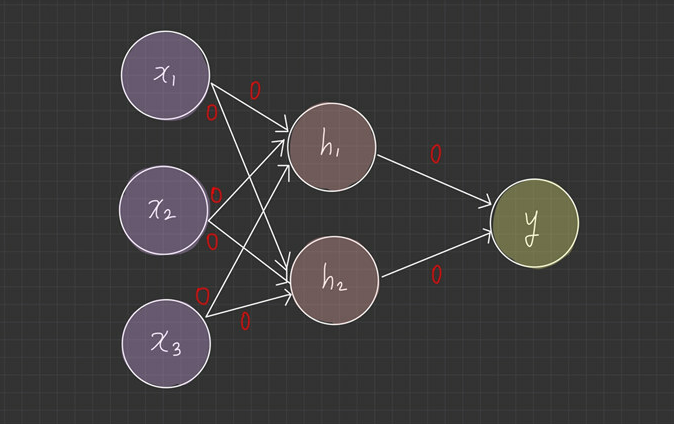

② 가중치 상수(예: 0.1)로 초기화<br>
가중 합산 결과도 같고, 활성 함수 실행 결과도 같음<br>
노드가 1개만 있는 것과 같음. 같은 계층의 모든 뉴런이 동일하게 동작

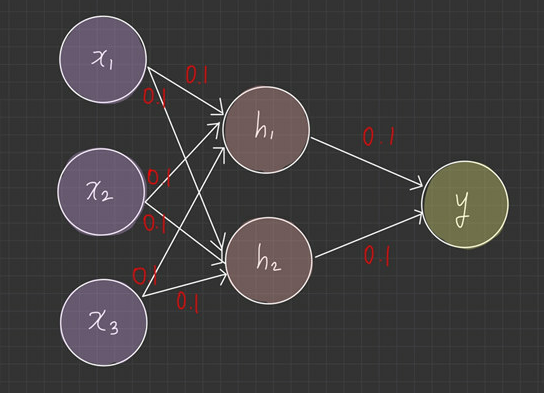

③ 다음 단계부터는
- 5 layer, 100 neuron/layer, 1000개 입력데이터
- 활성화 함수: sigmoid

③-1 가중치를 표준 편자 1인 정규분포로 초기화(입력값이 큰 경우)

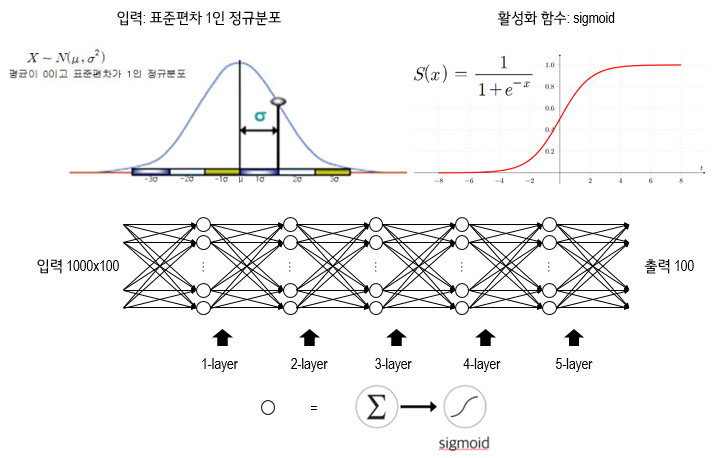

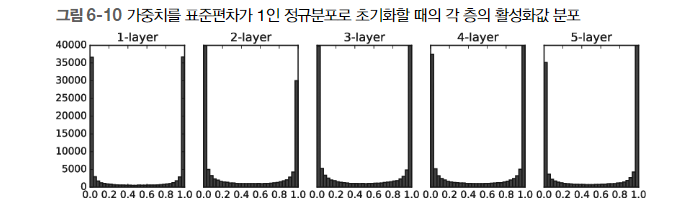

→ 0, 1에 치우침 발생...기울기 소실 문제 발생 여지...

③-2 가중치를 표준 편자 0.01인 정규분포로 초기화(입력값이 작은 경우)

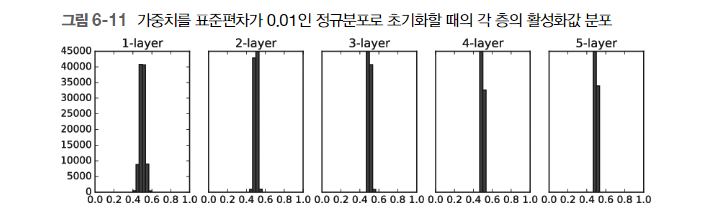

→ 다수의 뉴런이 거의 같은 값을 출력...뉴런 여러 개를 둔 의미 없어짐...표현력 제한 문제

③-1, ③-2에서처럼 입력값이 작거나 큰 것 모두 문제가 됨...

①, ②, ③에서 내린 결론은<br>
random하게 초깃값을 설정해야하고 적정한 가중치 초깃값 적용 필요!!!

해결책

- Xavier 초깃값: 좌우 대칭이고 중앙 부근이 선형인 sigmoid나 tanh와 같은 활성화 함수에 적용<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 각 층의 활성화 값을 광범위하게 분포시킬 목적<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 앞 층에 노드가 많을수록 대상 노드의 초깃값으로 설정하는 가중치가 좁게 퍼짐

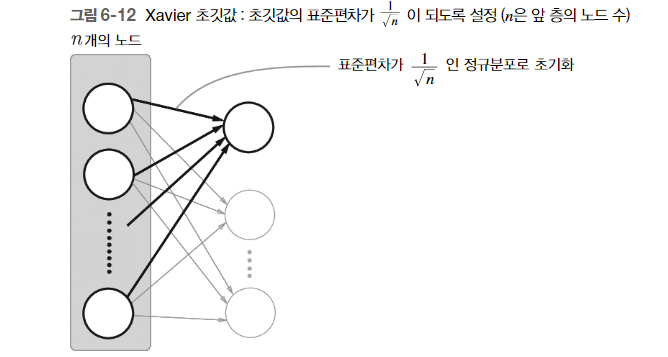

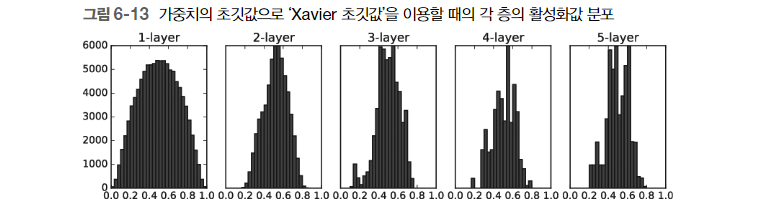

- He 초깃값: Relu에 특화된 초깃값<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Relu의 음의 영역이 0이라 Xavier 초깃값의 분포보다 더 넓게 분포시키기 위함

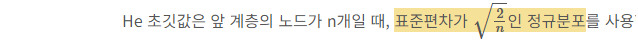

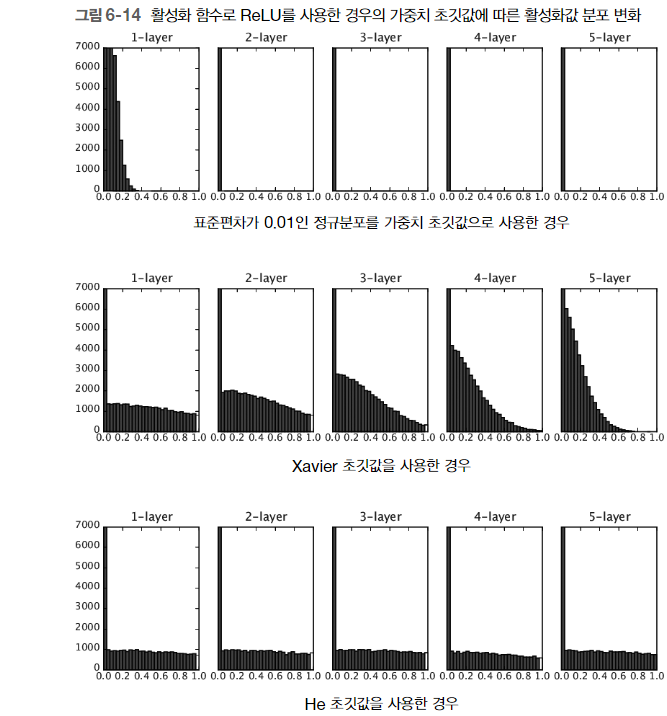

MNIST 데이터셋으로 살펴본 가중치 초깃값 중요성(뉴런 100개 5층 신경망, ReLU)

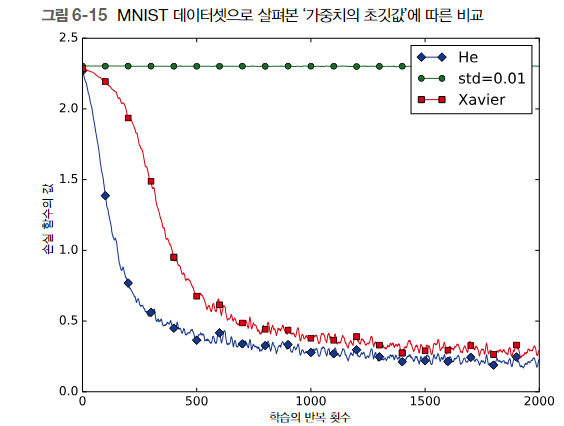

# ※ 가중치 초깃값 실습

(100, 100)
(1000, 100)
(100, 100)
(1000, 100)
(100, 100)
(1000, 100)
(100, 100)
(1000, 100)
(100, 100)
(1000, 100)


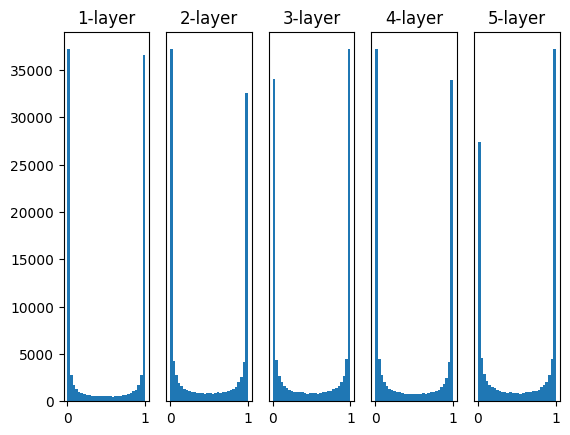

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)


input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
    w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)
    print(w.shape)
    a = np.dot(x, w)
    print(a.shape)

    # 활성화 함수도 바꿔가며 실험해보자！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0:
        plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0, 1))

plt.show()

--------------------------------------------------------------------------------

## 6.3 배치 정규화

-------------------------------------------------------------------------------<br>가중치 초깃값을 적절히 설정하면 각 층의 활성화값 분포가 적당히 퍼지면서 학습이 원할하게 수행됨을 확인<br>
→ 각 층이 활성화를 적당히 퍼뜨리도록 강제하면 학습이 잘될 것이다...
<br>
-------------------------------------------------------------------------------

학습 과정에서 각 층마다 입력 데이터의 분포가 변함 → Internal Covariate Shift

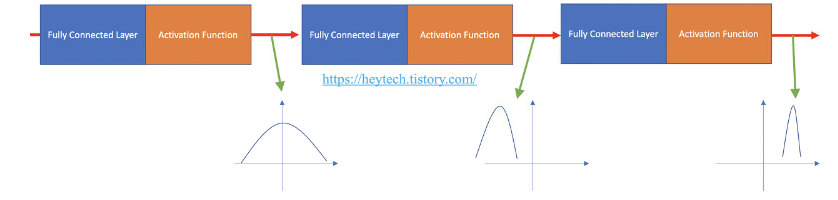

각 층에서의 활성화값이 적당히 분포되도록 조정!!!

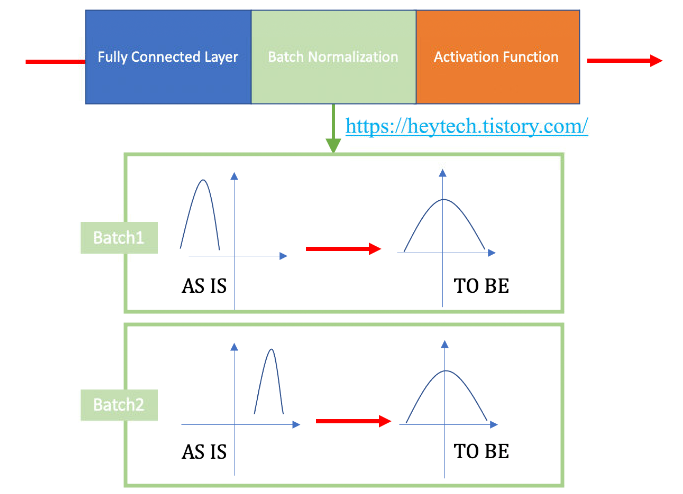

배치 정규화 장점
- 학습 속도 개선
- 초깃값에 의존하지 않음
- 오버피팅 억제(드롭아웃 등의 필요성 감소)
- Gradient Vanishing 문제 해결

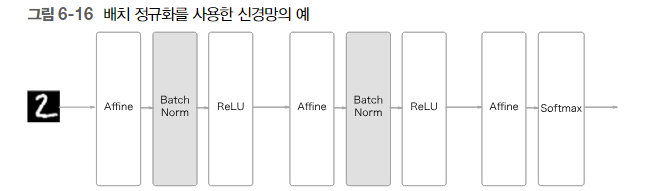

데이터 분포가 평균 0, 분산 1이 되도록 정규화

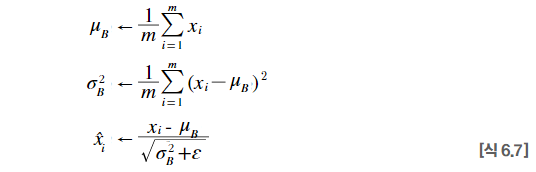

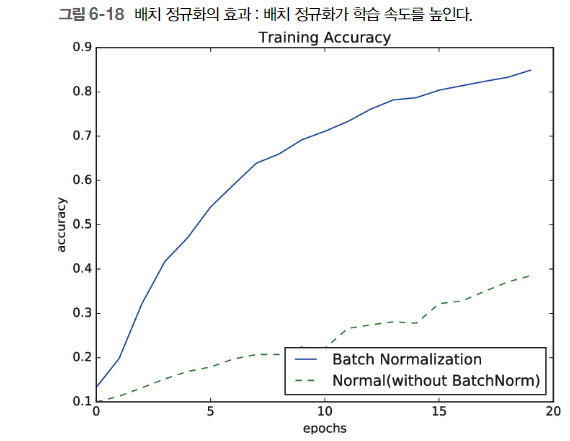

### ※ 배치 정규화 코드

In [ ]:
class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # 합성곱 계층은 4차원, 완전연결 계층은 2차원

        # 시험할 때 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var

        # backward 시에 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)

        return out.reshape(*self.input_shape)

    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)

        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std

            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))

        out = self.gamma * xn + self.beta
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size

        self.dgamma = dgamma
        self.dbeta = dbeta

        return dx

--------------------------------------------------------------------------------

### 6.4.1 오버피팅

- 매개변수가 많고 표현력이 높은 모델
- 훈련 데이터가 적음

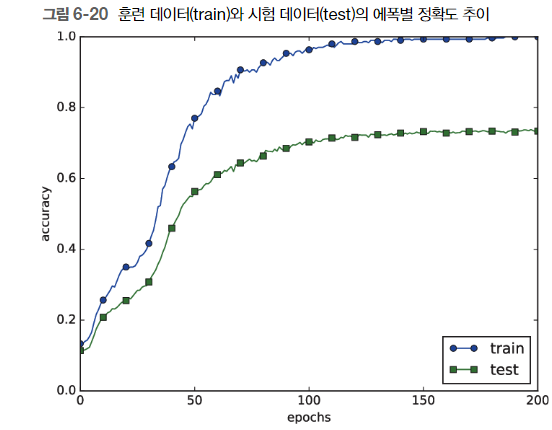

오버피팅 억제하는 방법들!!!

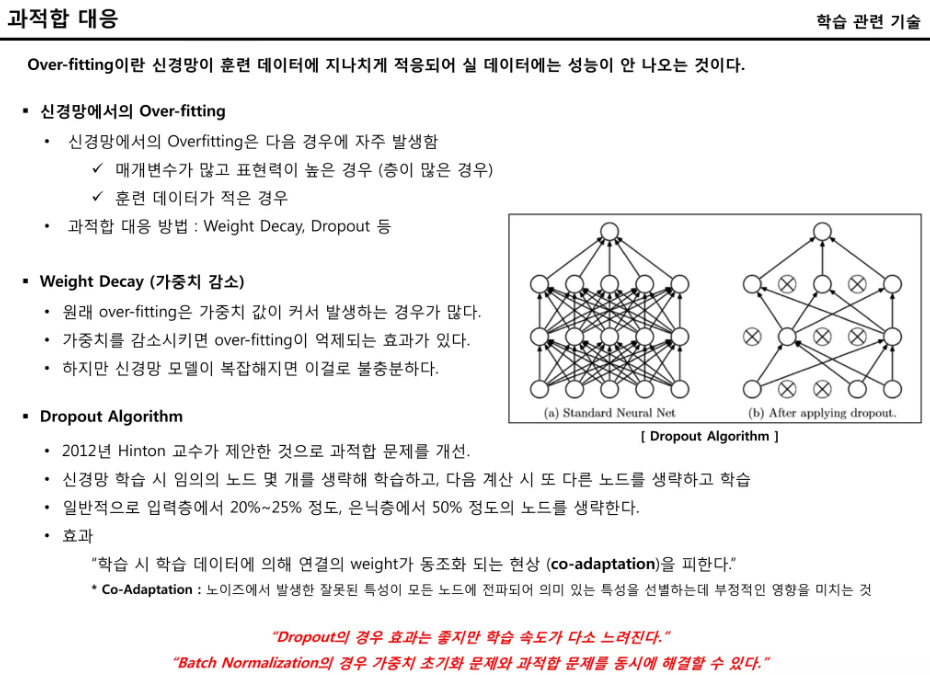

※ 추가 설명: 가중치 감소<br>
가중치가 크면 훈련 데이터의 feature에 강하게 학습되어 오버피팅 됨<br>

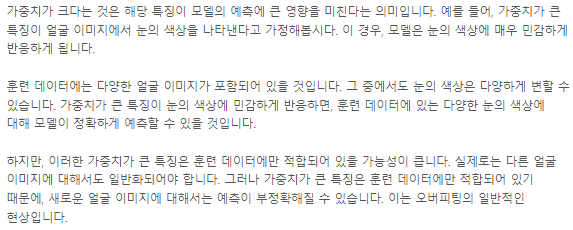

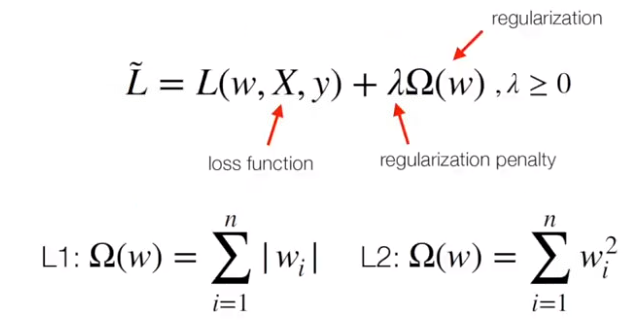


가중치가 크면 손실함수에 페널티를 더해서 dL/dw값이 커지고 가중치를 더 크게 변하게 만든다!!

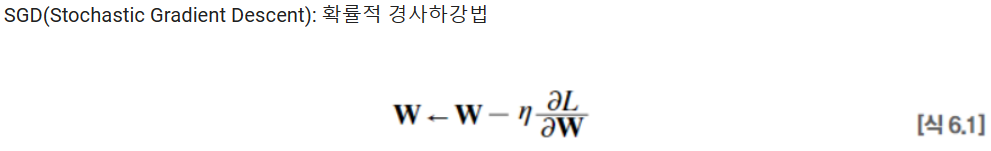

In [ ]:
    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        손실 함수의 값
        """
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2) # L2 regulation 적용

        return self.last_layer.forward(y, t) + weight_decay

가중치 감소 역전파 구현

In [ ]:
    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads

참고로 가중치가 0인 것의 뜻은 해당 feature는 중요하지 않다는 의미

※드롭아웃<br>
표현력(?)을 높이면서도 오버피팅 억제<br>
학습하는 동안 랜덤으로 모델 층의 일부 노드를 사용하지 않는데
추론시에는 모델의 모든 층을 사용<br>
특정 노드의 가중치들이 집중되는 것을 방지하고 앙상블 효과를 가질 수 있어 과적합을 막을 수 있음

In [ ]:
class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

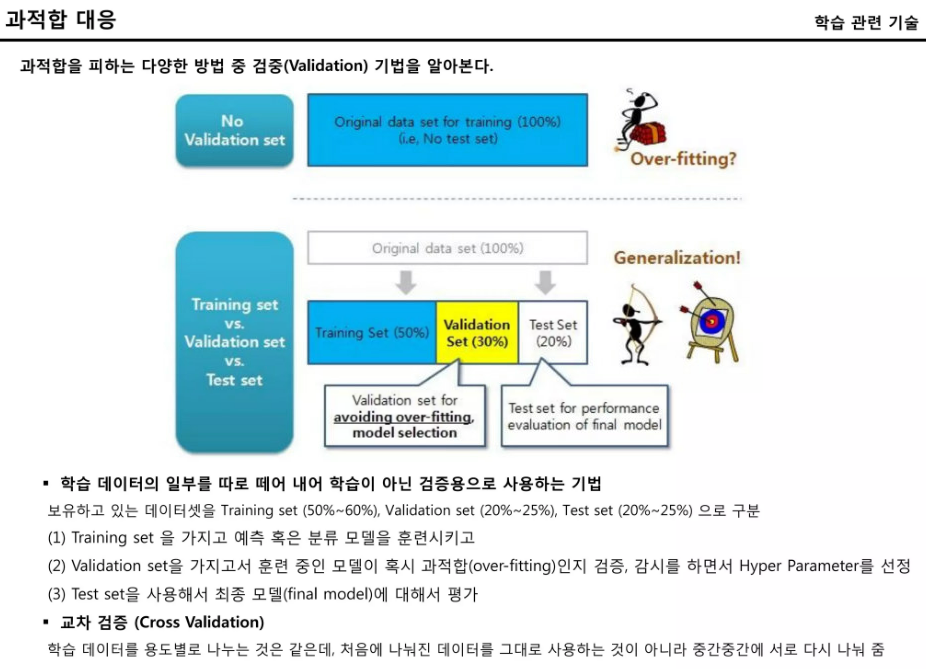

※ 하이퍼파라미터 튜닝 또한 과적합 대응